In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("llama-3.3-70b-versatile", model_provider="groq")

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

/Users/amyrfrancisco/Developer/projects/tm-rag-amyr/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from langchain_community.document_loaders import DirectoryLoader

loader = DirectoryLoader("docs", glob="**/*.pdf", show_progress=True, use_multithreading=True)
docs = loader.load()

len(docs)

100%|██████████| 1/1 [00:08<00:00,  8.01s/it]


1

In [5]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=250)
all_splits = text_splitter.split_documents(docs)

len(all_splits)

387

In [6]:
from langchain_chroma import Chroma

# vector_store = Chroma(
#     embedding_function=embeddings,
#     persist_directory="chroma_langchain_db"
# )

vector_store = Chroma.from_documents(all_splits, embeddings)

In [7]:
# _ = vector_store.add_documents(documents=all_splits)

In [21]:
from langchain_core.prompts import PromptTemplate

template = """
You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Refer to the 'context' as the 'document' but don't mention 'According to the document' or the likes when answering questions. Provide the answer directly.
Question: {question} 
Context: {context} 
Answer:
"""

custom_rag_prompt = PromptTemplate.from_template(template)

In [22]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict, Annotated

class Search(TypedDict):
    query: Annotated[str, ..., "Search query to run"]
    topic: Annotated[str, ..., "Topic of the query"]

class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer:str

In [32]:
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}

def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(query["query"])
    return {"context": retrieved_docs}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = custom_rag_prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [33]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

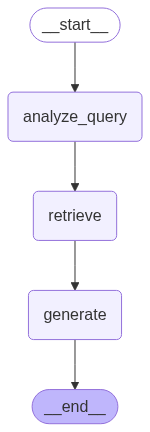

In [34]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
for step in graph.stream(
    {"question": "what do we look forward to in 2024?"},
    stream_mode="updates",
):
    print(f"{step}\n\n---------------------------\n")

{'analyze_query': {'query': {'query': '2024 upcoming events', 'topic': 'future events and trends'}}}

---------------------------

{'retrieve': {'context': [Document(id='2d6f4d1b-c265-411a-bcc8-1cc9bbde6a37', metadata={'source': 'docs/2023_Annual_Report.pdf'}, page_content='(In millions)\n\n2024\n\nThereafter\n\nLong-term debt: (a)\n\nPrincipal payments Interest payments\n\nConstruction commitments (b) Operating and finance leases, including imputed interest (c) Purchase commitments (d)\n\n$\n\n5,250 $ 1,379 12,237 5,988 64,703\n\n47,616 $ 19,746 1,218 73,852 3,115\n\nTotal\n\n$\n\n89,557 $\n\n145,547 $\n\n(a) Refer to Note 11 – Debt of the Notes to Financial Statements. (b) Refer to Note 7 – Property and Equipment of the Notes to Financial Statements. (c) Refer to Note 14 – Leases of the Notes to Financial Statements. (d) Purchase commitments primarily relate to datacenters and include open purchase orders and take-or-pay contracts\n\nthat are not presented as construction commitments

In [36]:
result = graph.invoke({"question": "summarize the documents for me"})

print(f'Context: {len(result["context"])}\n\n')
print(f'Answer: {result["answer"]}')

Context: 4


Answer: The document discusses Microsoft Corporation's financial performance, which is reported based on three segments: Productivity and Business Processes, Intelligent Cloud, and More Personal Computing. The company's financial statements are prepared in conformity with accounting principles generally accepted in the United States of America. The document also includes information on the company's management responsibility, accounting systems, and financial condition, as well as an analysis of its financial results and operations.
